# Section 8

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    #'text.latex.preamble': r"\usepackage{amsmath}"
})

In [2]:
import irbasis3
from numpy.fft import fftn, ifftn

## Generate IR basis by singular value expansion

In [3]:
lambda_ = 1e+5
beta = 1e+3
eps = 1e-7
# Number of divisions along each reciprocal lattice vector
# Note: For a smaller nk (e.g., 64), an unphysical small structures appear in the self-energy at low frequencies.
nk_lin = 256
U = 2.0 # Onsite repulsion

wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=lambda_)
basis = irbasis3.FiniteTempBasis(K, statistics="F", beta=beta, eps=eps)
L = basis.size

# Sparse sampling in tau
smpl_tau = irbasis3.TauSampling(basis)
ntau = smpl_tau.sampling_points.size
print("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = irbasis3.MatsubaraSampling(basis)
nw = smpl_matsu.sampling_points.size
print("cond (matsu): ", smpl_matsu.cond)

cond (tau):  178.7075709395494
cond (matsu):  248.85182514585554


## Step 1
Generate k mesh and compute non-interacting band energies

In [4]:
kps = (nk_lin, nk_lin)
nk = np.prod(kps)
nr = nk
kgrid = [2*np.pi*np.arange(kp)/kp for kp in kps]
k1, k2 = np.meshgrid(*kgrid, indexing="ij")
ek = -2*(np.cos(k1) + np.cos(k2))

## Step 2
Compute non-interacting Green's function on sampling frequencies

Text(0, 0.5, '$\\mathrm{Im}~G(\\mathrm{i}\\nu, \\Gamma)$')

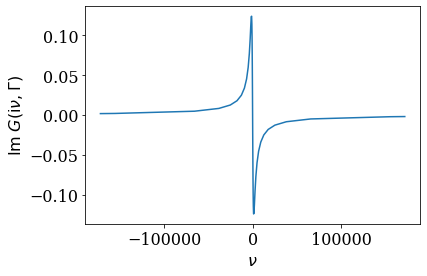

In [5]:
iv = 1j*np.pi*smpl_matsu.sampling_points/beta
gkf = 1.0 / (iv[:,None] - ek.ravel()[None,:])

plt.plot(smpl_matsu.sampling_points, gkf[:,0].imag)
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\mathrm{Im}~G(\mathrm{i}\nu, \Gamma)$")

Text(0, 0.5, '$|G(l, \\Gamma)|$')

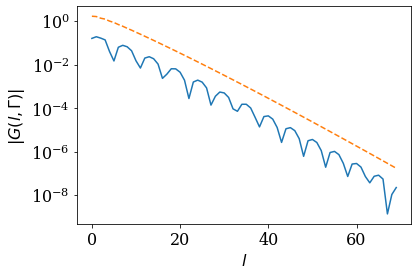

In [6]:
# G(l, k): (L, nk)
gkl = smpl_matsu.fit(gkf)

plt.semilogy(np.abs(gkl[:,0]))
plt.semilogy(basis.s, ls="--")
plt.xlabel(r"$l$")
plt.ylabel(r"$|G(l, \Gamma)|$")

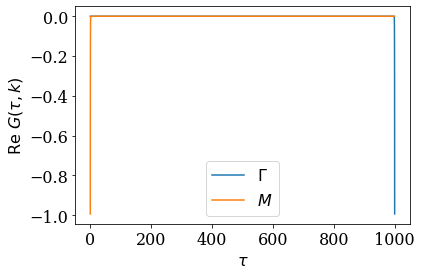

In [7]:
gkt = smpl_tau.evaluate(gkl)

plt.plot(smpl_tau.sampling_points, gkt[:,0].real, label=r'$\Gamma$')
plt.plot(smpl_tau.sampling_points, 
    gkt.reshape(-1,*kps)[:,nk_lin//2,nk_lin//2].real, label=r'$M$')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathrm{Re}~G(\tau, k)$")
plt.legend()

## Step 3
Transform the Green's function to the real space

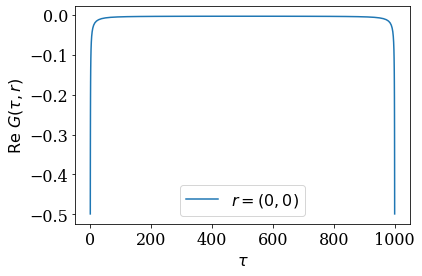

In [8]:
# Compute G(tau, r): (ntau, nk)
#  (1) Reshape gkt into shape of (ntau, nk_lin, nk_lin).
#  (2) Apply FFT to the axes 1, 2.
#  (3) Reshape the result to (ntau, nk)
# G(tau, k): (ntau, nk)
grt = fftn(gkt.reshape(ntau, *kps), axes=(1,2)).reshape(ntau, nk)/nk

plt.plot(smpl_tau.sampling_points, grt[:,0].real, label='$r=(0,0)$')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathrm{Re}~G(\tau, r)$")
plt.legend()

## Step 4
Compute the second-order term of the self-energy on the sampling points

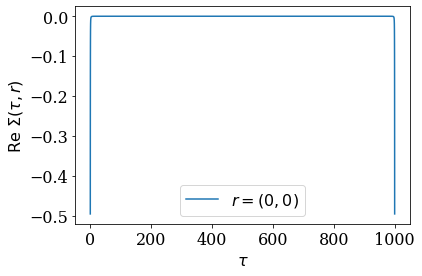

In [9]:
# Sigma(tau, r): (ntau, nr)
srt = U*U*grt*grt*grt[::-1,:]

plt.plot(smpl_tau.sampling_points, srt[:,0].real, label='$r=(0,0)$')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathrm{Re}~\Sigma(\tau, r)$")
plt.legend()

## Step 5
Transform the self-energy to the IR basis and then transform it to the k space

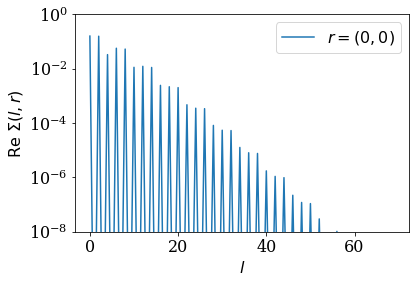

In [10]:
# Sigma(l, r): (L, nr)
srl = smpl_tau.fit(srt)
assert srl.shape == (L, nr)

plt.semilogy(np.abs(srl[:,0]), label='$r=(0,0)$')
plt.xlabel(r"$l$")
plt.ylabel(r"$\mathrm{Re}~\Sigma(l, r)$")
plt.ylim([1e-8,1])
plt.legend()

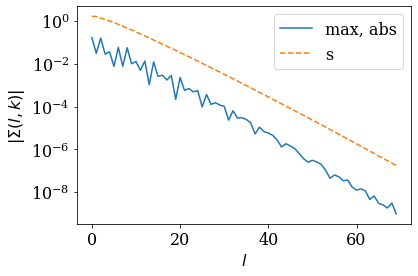

In [11]:
# Sigma(l, k): (L, nk)
srl = srl.reshape(L, *kps)
skl = ifftn(srl, axes=(1,2)) * nk
skl = skl.reshape(L, *kps)

plt.semilogy(np.max(np.abs(skl),axis=(1,2)), label="max, abs")
plt.semilogy(basis.s, label="s", ls="--")
plt.xlabel(r"$l$")
plt.ylabel(r"$|\Sigma(l, k)|$")
plt.legend()

## Step 6
Evaluate it on your favarite frequencies/times

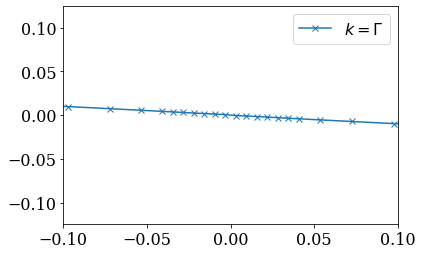

In [12]:
# Note: fermioic frequences must be represented by odd integers
#my_freqs = 2*np.arange(-100, 100)+1
my_freqs = smpl_matsu.sampling_points
uhatt = basis.uhat(my_freqs).T
res = np.einsum('wl, lIJ->wIJ', uhatt, skl)
plt.plot(my_freqs*np.pi/beta, res[:,0,0].imag, marker='x', label=r"$k=\Gamma$")
#plt.plot(my_freqs*np.pi/beta, res[:,nk_lin//2,nk_lin//2].imag, marker='o', label=r"$k=M$")
#plt.xlim([-0.1,0.1])
plt.legend()